In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import seaborn as sns

path = "outputs/"
algo_names = ["1nn", "cart", "mlp", "nb", "svm", "random_forest"]
def load_results_from_term(term):
    results_data = {}
    for algo_name in algo_names:
        path_full = glob.glob(path + "full_" + term + "_" + algo_name + "*")[0]
        path_reduced = glob.glob(path + "reduced_" + term + "_" + algo_name + "*")[0]
        print(path_full)
        print(path_reduced)
        results_data[algo_name] = {
            "full": json.load(open(path_full)),
            "reduced": json.load(open(path_reduced))
        }
    
    return results_data



arit = load_results_from_term("arit")
print("-----------------------")
esc = load_results_from_term("esc")
print("---------------------------")
leit = load_results_from_term("leit")

KeyboardInterrupt: 

In [2]:
arit_train_dataset = pd.read_csv("databases/AG/Aritmética/TreinamentoDesbalanceadoAritPreprocessada.csv", sep=";")
esc_train_dataset =   pd.read_csv("databases/AG/Escrita/TreinamentoDesbalanceadoEscPreprocessada.csv", sep=";")
leit_train_dataset = pd.read_csv("databases/AG/Leitura/TreinamentoDesbalanceadoLeitPreprocessada.csv", sep=";")

arit_train_dataset = arit_train_dataset.drop_duplicates(ignore_index=True)
esc_train_dataset = esc_train_dataset.drop_duplicates(ignore_index=True)
leit_train_dataset = leit_train_dataset.drop_duplicates(ignore_index=True)

leit_train_dataset


,Muito_peso,Medo_domir_sozinho,Mae_casada,HF_2grau,Comprimento_adequado,Comprimento_pequeno,Comprimento_grande,TDE_MG_Esc,Indulgencia,TDE_MG_Leit
0,0,0,1,0,0,1,0,2,12,Superior
1,0,0,1,0,1,0,0,2,12,Superior
2,0,0,0,0,1,0,0,0,8,Inferior
3,0,1,0,0,1,0,0,0,12,Inferior
4,0,0,0,0,0,0,1,0,12,Inferior
...,...,...,...,...,...,...,...,...,...,...
82,0,1,0,0,1,0,0,0,9,Inferior
83,0,0,1,0,1,0,0,0,17,Inferior
84,0,1,1,0,1,0,0,0,13,Inferior
85,0,1,0,1,0,1,0,0,24,Inferior


In [3]:
import hashlib

def create_counter_df(df, label_name):
    data = []
    for i, row in df.iterrows():
        str_row = str(row.to_list())
        hash_value = hashlib.sha256(str_row.encode('utf-8')).hexdigest()
        label = row[label_name]
        data.append([i, label, hash_value, 0])

    return pd.DataFrame(data=data, columns=["instance", "label", "hash", "freq"])

df_arit_counter = create_counter_df(arit_train_dataset, "TDE_MG_Arit")
df_esc_counter = create_counter_df(esc_train_dataset, "TDE_MG_Esc")
df_leit_counter = create_counter_df(leit_train_dataset, "TDE_MG_Leit")
df_leit_counter
# x = df_arit_counter.loc[df_arit_counter['hash'] == "6c9abdab20c6724493d948ae60ab733d2826f4aef387eb188ef00d72bee"]


,instance,label,hash,freq
0,0,Superior,41ccd064cc9bb7967514fc6a4dea5b8bf0bee86e329586...,0
1,1,Superior,bd58c4e26d5b1c8e0e7810950944ee1211ffac98976049...,0
2,2,Inferior,c7df85567deade21cce54b17adff26eb4337ee437a995a...,0
3,3,Inferior,52f7451c5bd71cbcf0569f1c4f00e4ffb74c5ab41fb433...,0
4,4,Inferior,c79fb56ce85fd5fe55337a776626d71a942af764b26db1...,0
...,...,...,...,...
82,82,Inferior,88cdc2b5b746d216b8e5b4909c23a64c066efd23896afd...,0
83,83,Inferior,a5f703e600a3107b0d93fec0b8d0834203a04a3439ff07...,0
84,84,Inferior,618080db74c5fffd8ae10b0986917e63b2148aec56bb47...,0
85,85,Inferior,0a0a569d578e3345a93776ad3df5e88e8b81965cf374d2...,0


In [4]:
def count_selected_instance_freq(database, counter_df):
    df = counter_df.copy()
    results = []
    for algo_name in algo_names:
        results.append(database[algo_name]["reduced"])

    for result in results:
        for key in result:
            if key.startswith('i'):
                selected_instances_in_cv = result[key]["selected_indices"]
                for selected_instances in selected_instances_in_cv:
                    for selected_instance in selected_instances:
                        df.loc[df['hash'] == selected_instance, 'freq'] += 1
        
    return df.sort_values(by='freq', ascending=False)

                   

selected_df_arit = count_selected_instance_freq(arit, df_arit_counter)
selected_df_esc = count_selected_instance_freq(esc, df_esc_counter)
selected_df_leit = count_selected_instance_freq(leit, df_leit_counter)

In [7]:
def get_original_data(df, original_df):
    instances = df['instance']
    return original_df.iloc[instances]
    

# Get 20% of most selected instance
arit_sup_selected = selected_df_arit[selected_df_arit['label'] == 'Superior']
top_instances = round(len(arit_sup_selected) * 0.25)
complete_selected_arit_sup = get_original_data(arit_sup_selected.head(top_instances), arit_train_dataset)

arit_inf_selected = selected_df_arit[selected_df_arit['label'] == 'Inferior']
top_instances = round(len(arit_inf_selected) * 0.25)
complete_selected_arit_inf = get_original_data(arit_inf_selected.head(top_instances), arit_train_dataset)

esc_sup_selected = selected_df_esc[selected_df_esc['label'] == 'Superior']
top_instances = round(len(esc_sup_selected) * 0.25)
complete_selected_esc_sup = get_original_data(esc_sup_selected.head(top_instances), esc_train_dataset)

esc_inf_selected = selected_df_esc[selected_df_esc['label'] == 'Inferior']
top_instances = round(len(esc_inf_selected) * 0.25)
complete_selected_esc_inf = get_original_data(esc_inf_selected.head(top_instances), esc_train_dataset)

leit_sup_selected = selected_df_leit[selected_df_leit['label'] == 'Superior']
top_instances = round(len(leit_sup_selected) * 0.25)
complete_selected_leit_sup = get_original_data(leit_sup_selected.head(top_instances), leit_train_dataset)

leit_inf_selected = selected_df_leit[selected_df_leit['label'] == 'Inferior']
top_instances = round(len(leit_inf_selected) * 0.25)
complete_selected_leit_inf = get_original_data(leit_inf_selected.head(top_instances), leit_train_dataset)

complete_selected_arit_sup.to_csv('outputs/mais_selecionadas_tdah_arit_sup.csv',index=False)
complete_selected_arit_inf.to_csv('outputs/mais_selecionadas_tdah_arit_inf.csv',index=False)
complete_selected_esc_sup.to_csv('outputs/mais_selecionadas_tdah_esc_sup.csv',index=False)
complete_selected_esc_inf.to_csv('outputs/mais_selecionadas_tdah_esc_inf.csv',index=False)
complete_selected_leit_sup.to_csv('outputs/mais_selecionadas_tdah_leit_sup.csv',index=False)
complete_selected_leit_inf.to_csv('outputs/mais_selecionadas_tdah_leit_inf.csv',index=False)


# Get instances not selected file
selected = selected_df_arit[(selected_df_arit['freq'] == 0) & (selected_df_arit['label'] == 'Superior')]
complete_selected_arit_sup = get_original_data(selected, arit_train_dataset)

selected = selected_df_arit[(selected_df_arit['freq'] == 0) & (selected_df_arit['label'] == 'Inferior')]
complete_selected_arit_inf = get_original_data(selected, arit_train_dataset)

selected = selected_df_esc[(selected_df_esc['freq'] == 0) & (selected_df_esc['label'] == 'Superior')]
complete_selected_esc_sup = get_original_data(selected, esc_train_dataset)

selected = selected_df_esc[(selected_df_esc['freq'] == 0) & (selected_df_esc['label'] == 'Inferior')]
complete_selected_esc_inf = get_original_data(selected, esc_train_dataset)

selected = selected_df_leit[(selected_df_leit['freq'] == 0) & (selected_df_leit['label'] == 'Superior')]
complete_selected_leit_sup = get_original_data(selected, leit_train_dataset)

selected = selected_df_leit[(selected_df_leit['freq'] == 0) & (selected_df_leit['label'] == 'Inferior')]
complete_selected_leit_inf = get_original_data(selected, leit_train_dataset)

complete_selected_arit_sup.to_csv('outputs/nao_selecionadas_tdah_arit_sup.csv',index=False)
complete_selected_arit_inf.to_csv('outputs/nao_selecionadas_tdah_arit_inf.csv',index=False)
complete_selected_esc_sup.to_csv('outputs/nao_selecionadas_tdah_esc_sup.csv',index=False)
complete_selected_esc_inf.to_csv('outputs/nao_selecionadas_tdah_esc_inf.csv',index=False)
complete_selected_leit_sup.to_csv('outputs/nao_selecionadas_tdah_leit_sup.csv',index=False)
complete_selected_leit_inf.to_csv('outputs/nao_selecionadas_tdah_leit_inf.csv',index=False)

<AxesSubplot:title={'center':'High class'}, xlabel='Instance Index'>

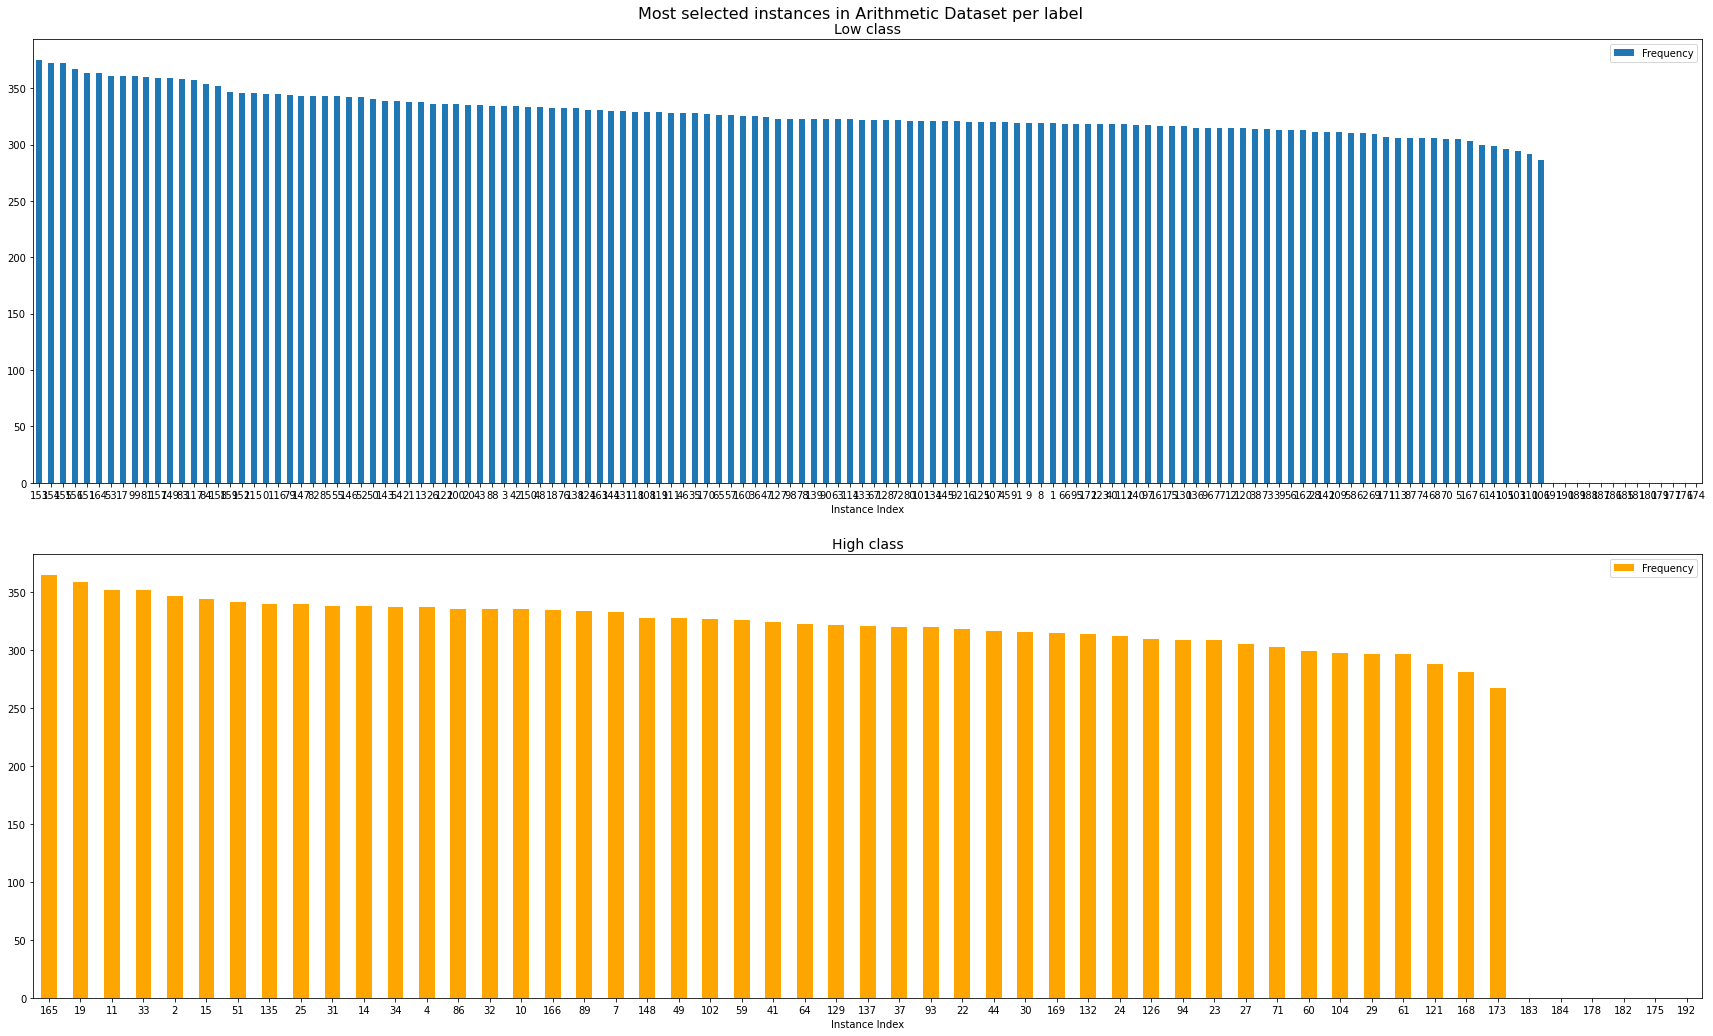

In [9]:
plt.rcParams['figure.figsize'] = (25, 15)
fig, axes = plt.subplots(2)
fig.tight_layout(pad=5.0)

plt.suptitle(f'Most selected instances in Arithmetic Dataset per label', fontsize=16)

arit_inf_selected = arit_inf_selected.rename(columns = {'instance': 'Instance Index', 'freq': 'Frequency'}, inplace = False)
arit_sup_selected = arit_sup_selected.rename(columns = {'instance': 'Instance Index', 'freq': 'Frequency'}, inplace = False)
esc_inf_selected = esc_inf_selected.rename(columns = {'instance': 'Instance Index', 'freq': 'Frequency'}, inplace = False)
esc_sup_selected = esc_sup_selected.rename(columns = {'instance': 'Instance Index', 'freq': 'Frequency'}, inplace = False)
leit_inf_selected = leit_inf_selected.rename(columns = {'instance': 'Instance Index', 'freq': 'Frequency'}, inplace = False)
leit_sup_selected = leit_sup_selected.rename(columns = {'instance': 'Instance Index', 'freq': 'Frequency'}, inplace = False)

axes[0].set_title('Low class', fontsize=14)
top_inf_instances = round(len(arit_inf_selected) * 0.25)
top_sup_instances = round(len(arit_sup_selected) * 0.25)
arit_inf_selected.plot.bar(x='Instance Index', y='Frequency', ax=axes[0], rot=0)

axes[1].set_title('High class', fontsize=14)
top_sup_instances = round(len(arit_sup_selected) * 0.25)
arit_sup_selected.plot.bar(x='Instance Index', y='Frequency', ax=axes[1], rot=0, color='orange')




140
53
169
50
62
25
[[381 377 370 363 361]
 [359 357 346 346 345]
 [343 341 340 338 336]
 [334 333 333 329 324]
 [320 314 310 102   0]]
[[17 59 18  5  1]
 [19 16 26 43  0]
 [33 40 34 53 37]
 [28 29 47 20 46]
 [54 24 23 78 79]]


Text(806.0, 0.5, 'Instance Index')

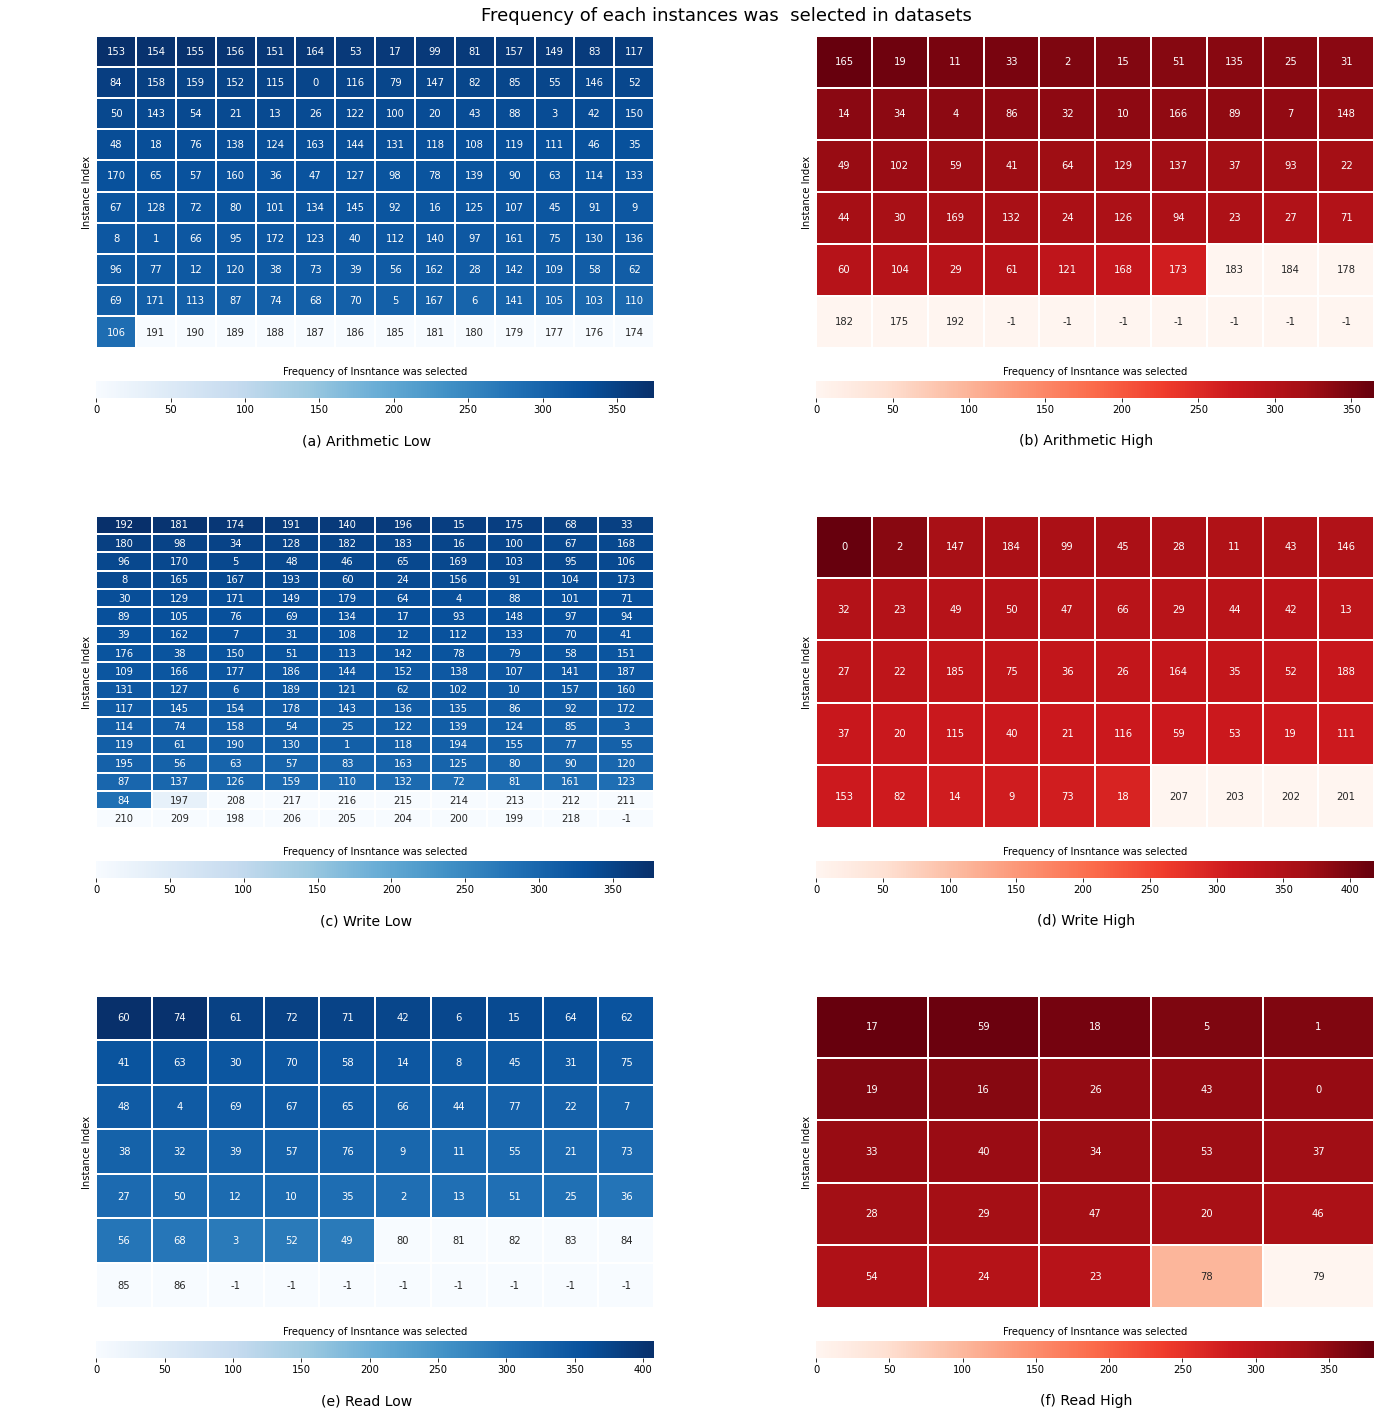

In [13]:
def create_heatmap_instances(freq, i, fig, pallete):
    grid_kws = {"height_ratios": (.9, .05), "hspace": .2}
    (ax, cbar_ax) = fig.subplots(2, gridspec_kw=grid_kws)
    cbar_ax.set_title("Frequency of Insntance was selected", fontsize=10)
    sns.heatmap(
    freq, 
    cmap =pallete,
    linewidths = 0.30, 
    annot=i,
    ax=ax,
    cbar_ax=cbar_ax,
    square=False, 
    fmt='g', 
    xticklabels=False, 
    yticklabels=False, 
    cbar_kws={
        "orientation": "horizontal",
    })
    
    return ax, cbar_ax



plt.rcParams['figure.figsize'] = (20, 20)

main_fig = plt.figure()

(fig_arit_inf, fig_arit_sup, fig_esc_inf, fig_esc_sup, fig_leit_inf, fig_leit_sup) = main_fig.subfigures(3,2).ravel()

data_arit_inf = pd.DataFrame(
    arit_inf_selected['Frequency'].to_numpy(), 
    columns=['freq'], 
    index=arit_inf_selected['Instance Index'].tolist())

print(len(data_arit_inf['freq']))
freq = data_arit_inf['freq'].to_numpy().reshape(10, 14)
i = data_arit_inf.index.to_numpy().reshape(10, 14).astype('int32')
ax_heat_arit_inf, ax_cbar_arit_inf = create_heatmap_instances(freq, i, fig_arit_inf, "Blues")


data_arit_sup = pd.DataFrame(
    arit_sup_selected['Frequency'].to_numpy(), 
    columns=['freq'], 
    index=arit_sup_selected['Instance Index'].tolist())
    
print(len(data_arit_sup['freq']))
freq = data_arit_sup['freq'].to_numpy().copy()
freq.resize(6,10)
i = data_arit_sup.index.to_numpy().copy()
i.resize(6,10)
i[-1, 3:] = -1
ax_heat_arit_sup, ax_cbar_arit_sup = create_heatmap_instances(freq, i, fig_arit_sup, "Reds")

data_esc_inf = pd.DataFrame(
    esc_inf_selected['Frequency'].to_numpy(), 
    columns=['freq'], 
    index=esc_inf_selected['Instance Index'].tolist())
    
print(len(data_esc_inf['freq']))
freq = data_esc_inf['freq'].to_numpy().copy()
freq.resize(17,10)
i = data_esc_inf.index.to_numpy().copy()
i.resize(17,10)
i[-1,-1] = -1
ax_heat_esc_inf, ax_cbar_arit_inf = create_heatmap_instances(freq, i, fig_esc_inf, "Blues")

data_esc_sup = pd.DataFrame(
    esc_sup_selected['Frequency'].to_numpy(), 
    columns=['freq'], 
    index=esc_sup_selected['Instance Index'].tolist())
    
print(len(data_esc_sup['freq']))
freq = data_esc_sup['freq'].to_numpy().reshape(5,10)
i = data_esc_sup.index.to_numpy().reshape(5,10)
ax_heat_esc_sup, ax_cbar_esc_sup = create_heatmap_instances(freq, i, fig_esc_sup, "Reds")

data_leit_inf = pd.DataFrame(
    leit_inf_selected['Frequency'].to_numpy(), 
    columns=['freq'], 
    index=leit_inf_selected['Instance Index'].tolist())
    
print(len(data_leit_inf['freq']))
freq = data_leit_inf['freq'].to_numpy().copy()
freq.resize(7,10)
i = data_leit_inf.index.to_numpy().copy()
i.resize(7,10)
i[-1,2:] = -1
ax_heat_leit_inf, ax_cbar_leit_inf = create_heatmap_instances(freq, i, fig_leit_inf, "Blues")

data_leit_sup = pd.DataFrame(
    leit_sup_selected['Frequency'].to_numpy(), 
    columns=['freq'], 
    index=leit_sup_selected['Instance Index'].tolist())

print(len(data_leit_sup['freq']))
freq = data_leit_sup['freq'].to_numpy().reshape(5,5)
i = data_leit_sup.index.to_numpy().reshape(5,5)
print(freq)
print(i)
# i[-1,4:] = -1
ax_heat_leit_sup, ax_cbar_leit_sup = create_heatmap_instances(freq, i, fig_leit_sup, "Reds")
main_fig.suptitle("Frequency of each instances was  selected in datasets", fontsize=18)

fig_arit_inf.suptitle("(a) Arithmetic Low", ha='center', fontsize=14, y=.05)
fig_arit_sup.suptitle("(b) Arithmetic High", ha='center', fontsize=14, y=.05)
fig_esc_inf.suptitle("(c) Write Low", ha='center', fontsize=14, y=.05)
fig_esc_sup.suptitle("(d) Write High", ha='center', fontsize=14, y=.05)
fig_leit_inf.suptitle("(e) Read Low", ha='center', fontsize=14, y=.05)
fig_leit_sup.suptitle("(f) Read High", ha='center', fontsize=14, y=.05)


ax_heat_arit_inf.set_ylabel('Instance Index')
ax_heat_arit_sup.set_ylabel('Instance Index')
ax_heat_esc_inf.set_ylabel('Instance Index')
ax_heat_esc_sup.set_ylabel('Instance Index')
ax_heat_leit_inf.set_ylabel('Instance Index')
ax_heat_leit_sup.set_ylabel('Instance Index')

# fig_arit_inf.text(.5, .025, "(c) Write Low", ha='center', fontsize=18)
# fig_arit_inf.text(.5, .025, "(d) Write High", ha='center', fontsize=18)
# fig_arit_inf.text(.5, .025, "(e) Read Low", ha='center', fontsize=18)
# fig_arit_inf.text(.5, .025, "(f) Read Low", ha='center', fontsize=18)

# # RdYlGn
# r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'
# 



# print(data2)

Text(0.5, 0.98, 'aaaaa')

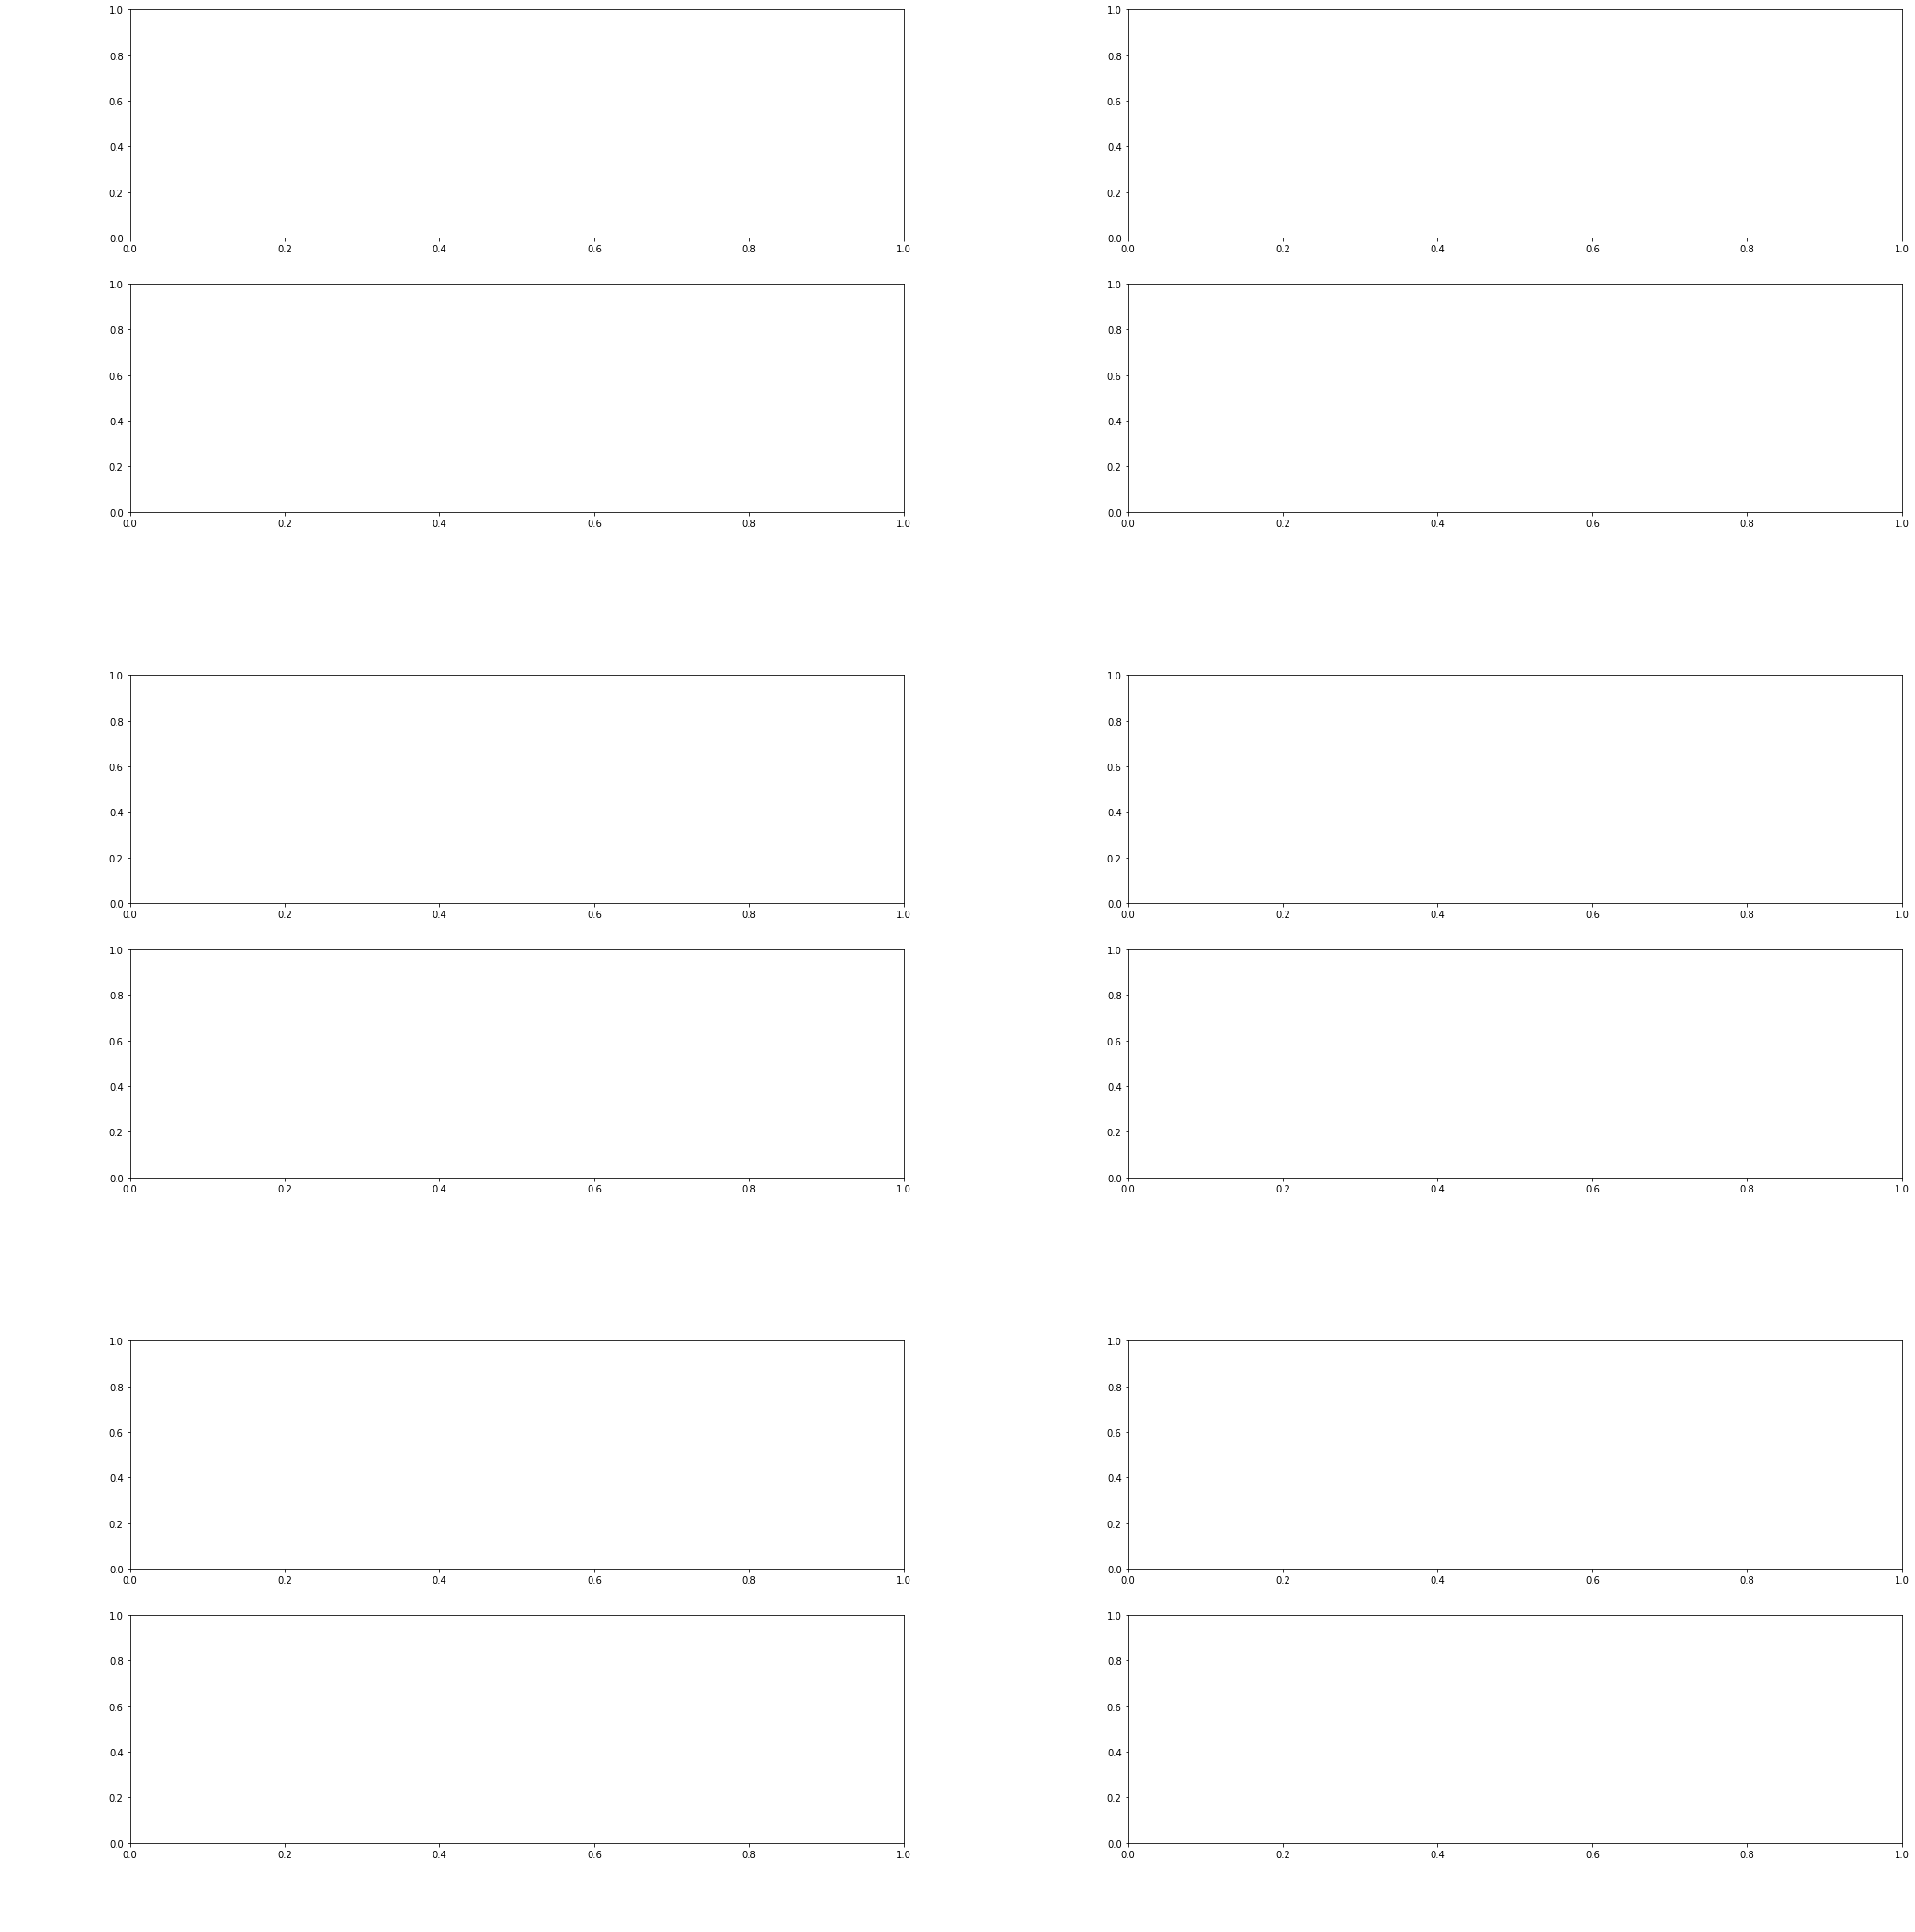

In [33]:
main_fig = plt.figure()
(fig_arit_inf, fig_arit_sup, fig_esc_inf, fig_esc_sup, fig_leit_inf, fig_leit_sup) = main_fig.subfigures(3,2).ravel()
fig_arit_inf.subplots(2)
fig_arit_sup.subplots(2)
fig_esc_inf.subplots(2)
fig_esc_sup.subplots(2)
fig_leit_inf.subplots(2)
fig_leit_sup.subplots(2)



# test[0][0].subplots(2)
# test[0][1].subplots(2)
# test[1][0].subplots(2)
# test[1][1].subplots(2)
# test[2][0].subplots(2)
# test[2][1].subplots(2)

<AxesSubplot:xlabel='instance'>

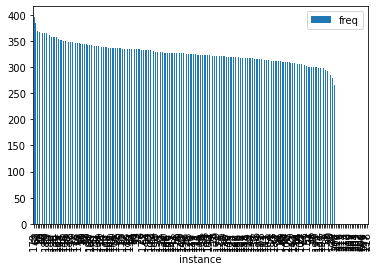

In [11]:
# selected_df.plot.bar(x="index", y="freq")



In [6]:
# class balance
def get_class_balance(data, reduced: bool):
    if reduced:
        label_result = "reduced"
    else:
        label_result = "full"

    results = []
    for algo_name in algo_names:
        results.append(data[algo_name][label_result])
    
    inferior_ratios = []
    supererior_ratios = []
    for result in results:
        for key in result:
            if key.startswith('i'):
                for ratios in result[key]['class_ratios']:
                    inferior_ratios.append(ratios['Inferior'])
                    supererior_ratios.append(ratios['Superior'])

    return inferior_ratios, supererior_ratios

reduced_inferior_arit, reduced_superior_arit = get_class_balance(arit, True)
reduced_inferior_esc, reduced_superior_esc = get_class_balance(esc, True)
reduced_inferior_leit, reduced_superior_leit = get_class_balance(leit, True)

full_inferior_arit, full_superior_arit = get_class_balance(arit, False)
full_inferior_esc, full_superior_esc = get_class_balance(esc, False)
full_inferior_leit, full_superior_leit = get_class_balance(leit, False)

print("--===Class analysys===---")
print(f"Mean Inferior arit: reduced: {np.mean(reduced_inferior_arit)}, full:{np.mean(full_inferior_arit)}")
print(f"Mean Superior arit: reduced: {np.mean(reduced_superior_esc)}, full:{np.mean(full_superior_arit)}")
print(f"Mean Inferior esc: reduced: {np.mean(reduced_inferior_esc)}, full:{np.mean(full_inferior_esc)}")
print(f"Mean Superior esc: reduced: {np.mean(reduced_superior_esc)}, full:{np.mean(full_superior_esc)}")
print(f"Mean Inferior leit: reduced: {np.mean(reduced_inferior_leit)}, full:{np.mean(full_inferior_leit)}")
print(f"Mean Superior leit: reduced: {np.mean(reduced_superior_leit)}, full:{np.mean(full_superior_leit)}")



--===Class analysys===---
Mean Inferior arit: reduced: 0.7304394475247188, full:0.7253936615507276
Mean Superior arit: reduced: 0.23366700854285413, full:0.2746063384492725
Mean Inferior esc: reduced: 0.7663329914571458, full:0.7716889709275494
Mean Superior esc: reduced: 0.23366700854285413, full:0.22831102907245038
Mean Inferior leit: reduced: 0.70183055156072, full:0.7126582278481011
Mean Superior leit: reduced: 0.29816944843927995, full:0.2873417721518987


In [14]:
import pandas as pd
def get_mean_class_metric(result, score_name, label, metric):
    metrics = []
    counter = 0
    for key in result:
        if key.startswith('i'):
            x = result[key][score_name][label][metric]
            metrics.append(x)
            counter+=1
    
    return sum(metrics) / counter

def get_metric_per_classes(database, metric: str, valid_base = False):
    score_name = ""
    if valid_base:
        score_name = "valid_scores"
    else:
        score_name = "scores"
    
    full_superior_list = []
    full_inferior_list = []
    full_avg_list = []
    reduced_superior_list = []
    reduced_inferior_list = []
    reducued_avg_list = []
    columns = []
    for algo_name in algo_names:
        full_superior = get_mean_class_metric(database[algo_name]["full"], score_name, "Superior", metric)
        full_inferior = get_mean_class_metric(database[algo_name]["full"], score_name, "Inferior", metric)
        full_avg = database[algo_name]["full"]["avg_" + score_name ][metric]
        full_superior_list.append(full_superior)
        full_inferior_list.append(full_inferior)
        full_avg_list.append(full_avg)

        reduced_superior = get_mean_class_metric(database[algo_name]["reduced"], score_name, "Superior", metric)
        reduced_inferior = get_mean_class_metric(database[algo_name]["reduced"], score_name, "Inferior", metric)
        reduced_avg = database[algo_name]["reduced"]["avg_" + score_name ][metric]
        reduced_superior_list.append(reduced_superior)
        reduced_inferior_list.append(reduced_inferior)
        reducued_avg_list.append(reduced_avg)

        columns += [algo_name, algo_name + "/Ant-IS"]


    row_superior = []
    for i in range(len(algo_names)):
        row_superior += [full_superior_list[i], reduced_superior_list[i]]

        
    row_inferior = []
    for i in range(len(algo_names)):
        row_inferior += [full_inferior_list[i], reduced_inferior_list[i]]
        
    row_avg = []
    for i in range(len(algo_names)):
        row_avg += [full_avg_list[i], reducued_avg_list[i]]

    rows = np.zeros((3,12))
    rows[0] = row_superior
    rows[1] = row_inferior
    rows[2] = row_avg

    return pd.DataFrame(rows, columns=columns, index=["Superior", "Inferior", "Média"])

metric_names = ["precision","recall","f1-score","support"]
x = get_metric_per_classes(arit, "recall")
y = get_metric_per_classes(esc, "recall")
z = get_metric_per_classes(leit, "recall")
print(get_metric_per_classes(arit, "recall"))
print(get_metric_per_classes(esc, "recall"))
print(get_metric_per_classes(leit, "recall"))
print((x['random_forest'].loc['Superior'] + y[ 'random_forest'].loc['Superior'] + z[ 'random_forest'].loc['Superior']) / 3)
print((x['random_forest/Ant-IS'].loc['Superior'] + y[ 'random_forest/Ant-IS'].loc['Superior'] + z[ 'random_forest/Ant-IS'].loc['Superior']) / 3)


               1nn  1nn/Ant-IS      cart  cart/Ant-IS       mlp  mlp/Ant-IS  \
Superior  0.654000    0.799500  0.718333     0.788367  0.474000    0.663000   
Inferior  0.887857    0.931714  0.840714     0.927000  0.912143    0.917143   
Média     0.770929    0.865607  0.779524     0.857683  0.693071    0.790071   

                nb  nb/Ant-IS  svm  svm/Ant-IS  random_forest  \
Superior  0.664667   0.760700  0.0         0.0       0.645000   
Inferior  0.813571   0.686214  1.0         1.0       0.911429   
Média     0.739119   0.723457  0.5         0.5       0.778214   

          random_forest/Ant-IS  
Superior              0.757300  
Inferior              0.960857  
Média                 0.859079  
               1nn  1nn/Ant-IS      cart  cart/Ant-IS       mlp  mlp/Ant-IS  \
Superior  0.446000    0.698400  0.626000     0.830800  0.338000    0.485200   
Inferior  0.881544    0.914246  0.906250     0.939048  0.960772    0.979463   
Média     0.663772    0.806323  0.766125     0.884924

[81.4211, 79.2632, 79.7895, 75.2632, 72.5789, 81.9737]
[89.4026, 88.6526, 85.0421, 70.8921, 72.5789, 90.3816]
[56.75, 48.5, 54.25, 56.25, 72.5, 60.5]
[50.15, 48.675, 50.025, 55.35, 72.5, 53.25]


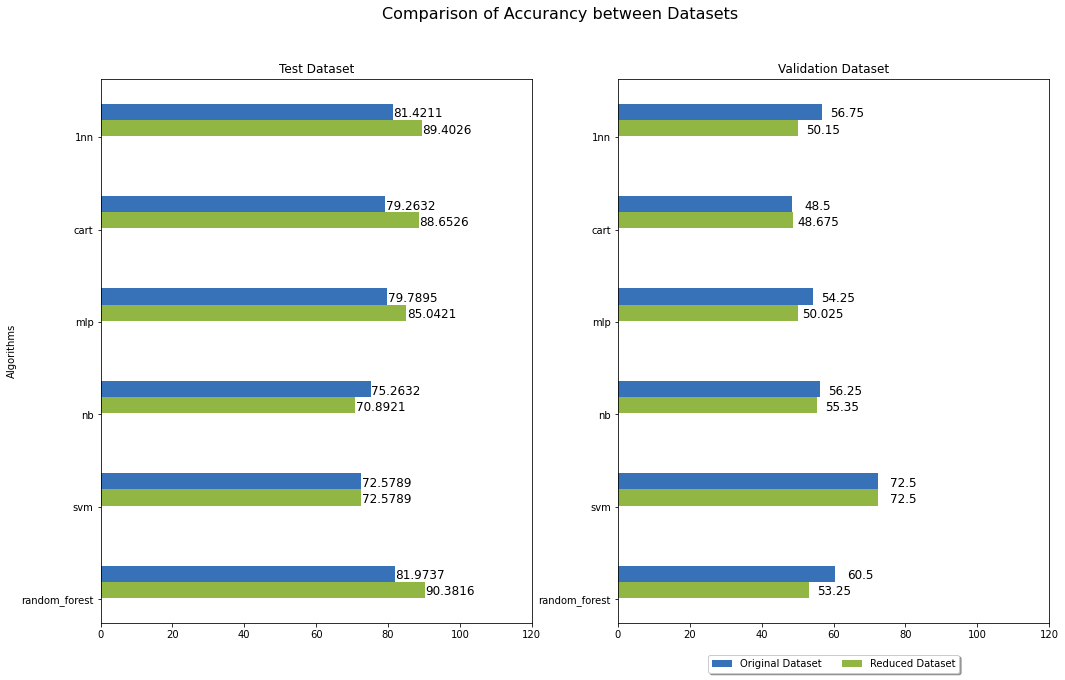

In [ ]:
def get_accuracy_per_test(test_result: dict, score_name: str):
    results = []
    counter = 0
    for key in test_result.keys():
        if key.startswith('i'):
            result = test_result[key][score_name]["accuracy"]
            results.append(result)
            counter+=1

    return sum(results) / counter

def autolabel(ax, rects):
    for rect in rects:
        width = rect.get_width()
        height = rect.get_height()
        ypos = rect.get_y() + height/2
        ax.text(width + 7.0, ypos - 0.11, width, ha='center', va='bottom', rotation=0, fontsize=12) 

# acuracia base de treino
full_accuracy_train = [round(get_accuracy_per_test(arit[algo_name]["full"], "scores")*100, 4) for algo_name in algo_names]
reduced_accuracy_train = [round(get_accuracy_per_test(arit[algo_name]["reduced"], "scores")*100, 4) for algo_name in algo_names]
print(full_accuracy_train)
print(reduced_accuracy_train)


# acuracias basse de validacao
full_accuracy_valid = [round(get_accuracy_per_test(arit[algo_name]["full"], "valid_scores")*100, 4) for algo_name in algo_names]
reduced_accuracy_valid = [round(get_accuracy_per_test(arit[algo_name]["reduced"], "valid_scores")*100, 4)for algo_name in algo_names]
print(full_accuracy_valid)
print(reduced_accuracy_valid)



#Valores dos agrupamentos
Borro_precision = [49.3, 29.5, 51.5, 89.1, 75.6, 28.3, 53.9]
Leijoto_precision = [62.1, 73.5, 62.1, 78.6, 75.5, 76.7, 71.4]
Santos_precision  = [69.7, 65.3, 96.2, 100.0, 69.8, 86.3, 78.4]
Metodologia_precision  = [65.0, 73.6, 80.0, 87.0,  74.5, 83.9, 77.3]

#Valores dos agrupamentos
Borro_recall = [38.5, 24.0, 42.0, 62.8, 36.0, 69.1, 45.4]
Leijoto_recall = [72.5, 65.8, 60.0, 61.1, 70.2, 75.8, 67.6]
Santos_recall = [84.6, 60.3, 75.4, 62.5, 66.1, 85.2, 72.4]
Metodologia_recall = [79.7, 68.0, 50.0, 64.5, 69.1, 87.0, 69.7]

#Valores dos agrupamentos
Borro_fmeasure = [43.2, 26.5, 46.3, 73.7, 48.8, 40.1, 46.4]
Leijoto_fmeasure = [66.9, 69.4, 61.0, 68.8, 72.7, 76.3, 69.2]
Santos_fmeasure = [76.4, 62.7, 82.1, 71.4, 67.9, 85.7, 74.4]
Metodologia_fmeasure = [72.0, 71.1, 61.5, 74.1, 71.7, 85.5, 72.7]

#Definindo o numero de colunas e o numero de agrupamentos
number_columns = len(algo_names)
number_groups = 2

# Definindo a largura das barras
barWidth = 0.21

#Espaçamento entre barras
espacamentoEntreBarras = 0.00

#espaçamento de um grupo no outro
espacamentoEntreGrupos = 1.2

# Aumentando o gráfico
plt.rcParams['figure.figsize'] = (17,10)

# fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3)
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2)

# Definindo a posição das barras
r1 = [(x * espacamentoEntreGrupos + espacamentoEntreBarras) *-1 for x in range(number_columns)]
r2 = [(x - barWidth - espacamentoEntreBarras) for x in r1]
# r3 = [x - barWidth - espacamentoEntreBarras for x in r2]
# r4 = [x - barWidth - espacamentoEntreBarras for x in r3]
 
# Criando as barras
label1 = ax0.barh(r1, full_accuracy_train, barWidth, color='#3771B8', label='Original Dataset')
label2 = ax0.barh(r2, reduced_accuracy_train, barWidth, color='#91B643', label='Reduced Dataset')
# label3 = ax0.barh(r3, Santos_precision, barWidth, color='#AF3330', label='Santos (2016)')
# label4 = ax0.barh(r4, Metodologia_precision, barWidth, color='#3771B8', label='Metodologia Proposta')

ax0.set_xticks(np.arange(0, 140, 20))
ax0.set_yticks([r - barWidth - espacamentoEntreBarras - 0.12 for r in r1])
# ax0.set_yticklabels(['Tra.', 'Oxi.', 'Lia.', 'Lig.', 'Iso.', 'Hid.', 'Ave.'])
ax0.set_yticklabels(algo_names)
ax0.set_title('Test Dataset')
ax0.set_ylabel('Algorithms')

autolabel(ax0, label1)
autolabel(ax0, label2)
# autolabel(ax0, label3)
# autolabel(ax0, label4)


# Criando as barras
label1 = ax1.barh(r1, full_accuracy_valid, barWidth, color='#3771B8', label='Original Dataset')
label2 = ax1.barh(r2, reduced_accuracy_valid, barWidth, color='#91B643', label='Reduced Dataset')
# label3 = ax1.barh(r3, Santos_recall, barWidth, color='#AF3330', label='Santos (2016)')
# label4 = ax1.barh(r4, Metodologia_recall, barWidth, color='#3771B8', label='Metodologia Proposta')

ax1.set_xticks(np.arange(0, 140, 20))
ax1.set_yticks([r - barWidth - espacamentoEntreBarras - 0.12 for r in r1])
ax1.set_yticklabels(algo_names)
ax1.set_title('Validation Dataset')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)

autolabel(ax1, label1)
autolabel(ax1, label2)
# autolabel(ax1, label3)
# autolabel(ax1, label4)


# Criando as barras
# label1 = ax2.barh(r1, Borro_fmeasure, barWidth, color='#704F97', label='Borro et al (2006)')
# label2 = ax2.barh(r2, Leijoto_fmeasure, barWidth, color='#91B643', label='Leijôto (2014)')
# label3 = ax2.barh(r3, Santos_fmeasure, barWidth, color='#AF3330', label='Santos (2016)')
# label4 = ax2.barh(r4, Metodologia_fmeasure, barWidth, color='#3771B8', label='Metodologia Proposta')

# ax2.set_xticks(np.arange(0, 140, 20))
# ax2.set_yticks([r - barWidth - espacamentoEntreBarras - 0.12 for r in r1])
# ax2.set_yticklabels(['Tra.', 'Oxi.', 'Lia.', 'Lig.', 'Iso.', 'Hid.', 'Ave.'])
# ax2.set_title('F-Measure')

# autolabel(ax2, label1)
# autolabel(ax2, label2)
# autolabel(ax2, label3)
# autolabel(ax2, label4) 

plt.suptitle('Comparison of Accurancy between Datasets', fontsize=16)
plt.show()

In [16]:
metric = "accuracy"


valid_precison_df = get_mean_class_metric()

# acuracia base de treino
full_arit = [round(arit[algo_name]["full"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
full_esc = [round(esc[algo_name]["full"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
full_leit = [round(leit[algo_name]["full"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]

reduced_arit = [round(arit[algo_name]["reduced"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
reduced_esc = [round(esc[algo_name]["reduced"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
reduced_leit = [round(leit[algo_name]["reduced"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]



#Definindo o numero de colunas e o numero de agrupamentos
number_columns = len(algo_names)
number_groups = 3

# Definindo a largura das barras
barWidth = 0.21

#Espaçamento entre barras
espacamentoEntreBarras = 0.00

#espaçamento de um grupo no outro
espacamentoEntreGrupos = 1.2

# Aumentando o gráfico
plt.rcParams['figure.figsize'] = (17,10)

# fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3)
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2)

# Definindo a posição das barras
r1 = [(x * espacamentoEntreGrupos + espacamentoEntreBarras) *-1 for x in range(number_columns)]
r2 = [(x - barWidth - espacamentoEntreBarras) for x in r1]
r3 = [x - barWidth - espacamentoEntreBarras for x in r2]
# r4 = [x - barWidth - espacamentoEntreBarras for x in r3]
 
# Criando as barras
label1 = ax0.barh(r1, full_arit, barWidth, color='#3771B8', label='TDAH ARIT')
label2 = ax0.barh(r2, full_esc, barWidth, color='#91B643', label='TDAH ESC')
label3 = ax0.barh(r3, full_leit, barWidth, color='#AF3330', label='TDAH LEIT')

ax0.set_xticks(np.arange(0, 140, 20))
ax0.set_yticks([r - barWidth - espacamentoEntreBarras - 0.12 for r in r1])
ax0.set_yticklabels(algo_names)
ax0.set_title('Original Dataset')
ax0.set_ylabel('Algorithms')

autolabel(ax0, label1)
autolabel(ax0, label2)
autolabel(ax0, label3)


# Criando as barras
label1 = ax1.barh(r1, reduced_arit, barWidth, color='#3771B8', label='TDAH ARIT')
label2 = ax1.barh(r2, reduced_esc, barWidth, color='#91B643', label='TDAH ESC')
label3 = ax1.barh(r3, reduced_leit, barWidth, color='#AF3330', label='TDAH LEIT')

ax1.set_xticks(np.arange(0, 140, 20))
ax1.set_yticks([r - barWidth - espacamentoEntreBarras - 0.12 for r in r1])
ax1.set_yticklabels(algo_names)
ax1.set_title('Reduced Dataset')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)

autolabel(ax1, label1)
autolabel(ax1, label2)
autolabel(ax1, label3)


plt.suptitle(f'Comparison of {metric}', fontsize=16)
plt.show()

TypeError: get_mean_class_metric() missing 4 required positional arguments: 'result', 'score_name', 'label', and 'metric'

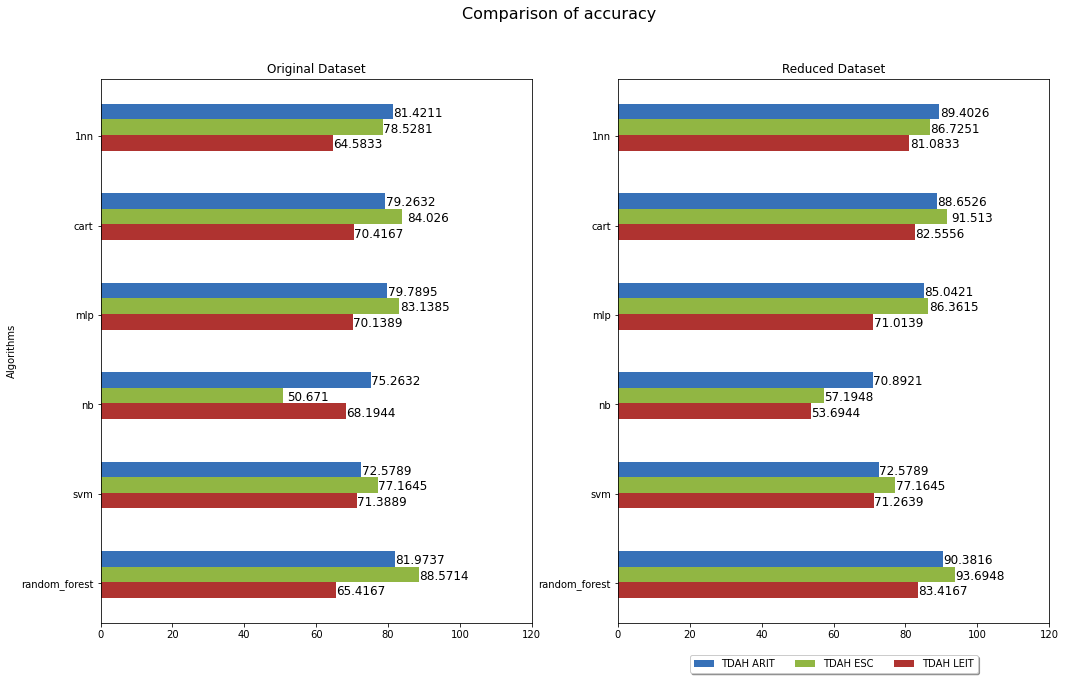

In [18]:
metric = "accuracy"

# acuracia base de treino
full_arit = [round(arit[algo_name]["full"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
full_esc = [round(esc[algo_name]["full"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
full_leit = [round(leit[algo_name]["full"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]

reduced_arit = [round(arit[algo_name]["reduced"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
reduced_esc = [round(esc[algo_name]["reduced"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]
reduced_leit = [round(leit[algo_name]["reduced"]["avg_scores"][metric]*100, 4) for algo_name in algo_names]



#Definindo o numero de colunas e o numero de agrupamentos
number_columns = len(algo_names)
number_groups = 3

# Definindo a largura das barras
barWidth = 0.21

#Espaçamento entre barras
espacamentoEntreBarras = 0.00

#espaçamento de um grupo no outro
espacamentoEntreGrupos = 1.2

# Aumentando o gráfico
plt.rcParams['figure.figsize'] = (17,10)

# fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3)
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2)

# Definindo a posição das barras
r1 = [(x * espacamentoEntreGrupos + espacamentoEntreBarras) *-1 for x in range(number_columns)]
r2 = [(x - barWidth - espacamentoEntreBarras) for x in r1]
r3 = [x - barWidth - espacamentoEntreBarras for x in r2]
# r4 = [x - barWidth - espacamentoEntreBarras for x in r3]
 
# Criando as barras
label1 = ax0.barh(r1, full_arit, barWidth, color='#3771B8', label='TDAH ARIT')
label2 = ax0.barh(r2, full_esc, barWidth, color='#91B643', label='TDAH ESC')
label3 = ax0.barh(r3, full_leit, barWidth, color='#AF3330', label='TDAH LEIT')

ax0.set_xticks(np.arange(0, 140, 20))
ax0.set_yticks([r - barWidth - espacamentoEntreBarras - 0.12 for r in r1])
ax0.set_yticklabels(algo_names)
ax0.set_title('Original Dataset')
ax0.set_ylabel('Algorithms')

autolabel(ax0, label1)
autolabel(ax0, label2)
autolabel(ax0, label3)


# Criando as barras
label1 = ax1.barh(r1, reduced_arit, barWidth, color='#3771B8', label='TDAH ARIT')
label2 = ax1.barh(r2, reduced_esc, barWidth, color='#91B643', label='TDAH ESC')
label3 = ax1.barh(r3, reduced_leit, barWidth, color='#AF3330', label='TDAH LEIT')

ax1.set_xticks(np.arange(0, 140, 20))
ax1.set_yticks([r - barWidth - espacamentoEntreBarras - 0.12 for r in r1])
ax1.set_yticklabels(algo_names)
ax1.set_title('Reduced Dataset')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)

autolabel(ax1, label1)
autolabel(ax1, label2)
autolabel(ax1, label3)


plt.suptitle(f'Comparison of {metric}', fontsize=16)
plt.show()

In [22]:
from typing import *
arit_valid_precision_df = get_metric_per_classes(arit, "precision")
arit_test_precision_df = get_metric_per_classes(arit, "precision", valid_base=True)
arit_valid_recall_df = get_metric_per_classes(arit, "recall")
arit_test_recall_df = get_metric_per_classes(arit, "recall", valid_base=True)
arit_valid_fmeasure_df = get_metric_per_classes(arit, "f1-score")
arit_test_fmeasure_df = get_metric_per_classes(arit, "f1-score", valid_base=True)

esc_valid_precision_df = get_metric_per_classes(esc, "precision")
esc_test_precision_df = get_metric_per_classes(esc, "precision", valid_base=True)
esc_valid_recall_df = get_metric_per_classes(esc, "recall")
esc_test_recall_df = get_metric_per_classes(esc, "recall", valid_base=True)
esc_valid_fmeasure_df = get_metric_per_classes(esc, "f1-score")
esc_test_fmeasure_df = get_metric_per_classes(esc, "f1-score", valid_base=True)

leit_valid_precision_df = get_metric_per_classes(leit, "precision")
leit_test_precision_df = get_metric_per_classes(leit, "precision", valid_base=True)
leit_valid_recall_df = get_metric_per_classes(leit, "recall")
leit_test_recall_df = get_metric_per_classes(leit, "recall", valid_base=True)
leit_valid_fmeasure_df = get_metric_per_classes(leit, "f1-score")
leit_test_fmeasure_df = get_metric_per_classes(leit, "f1-score", valid_base=True)

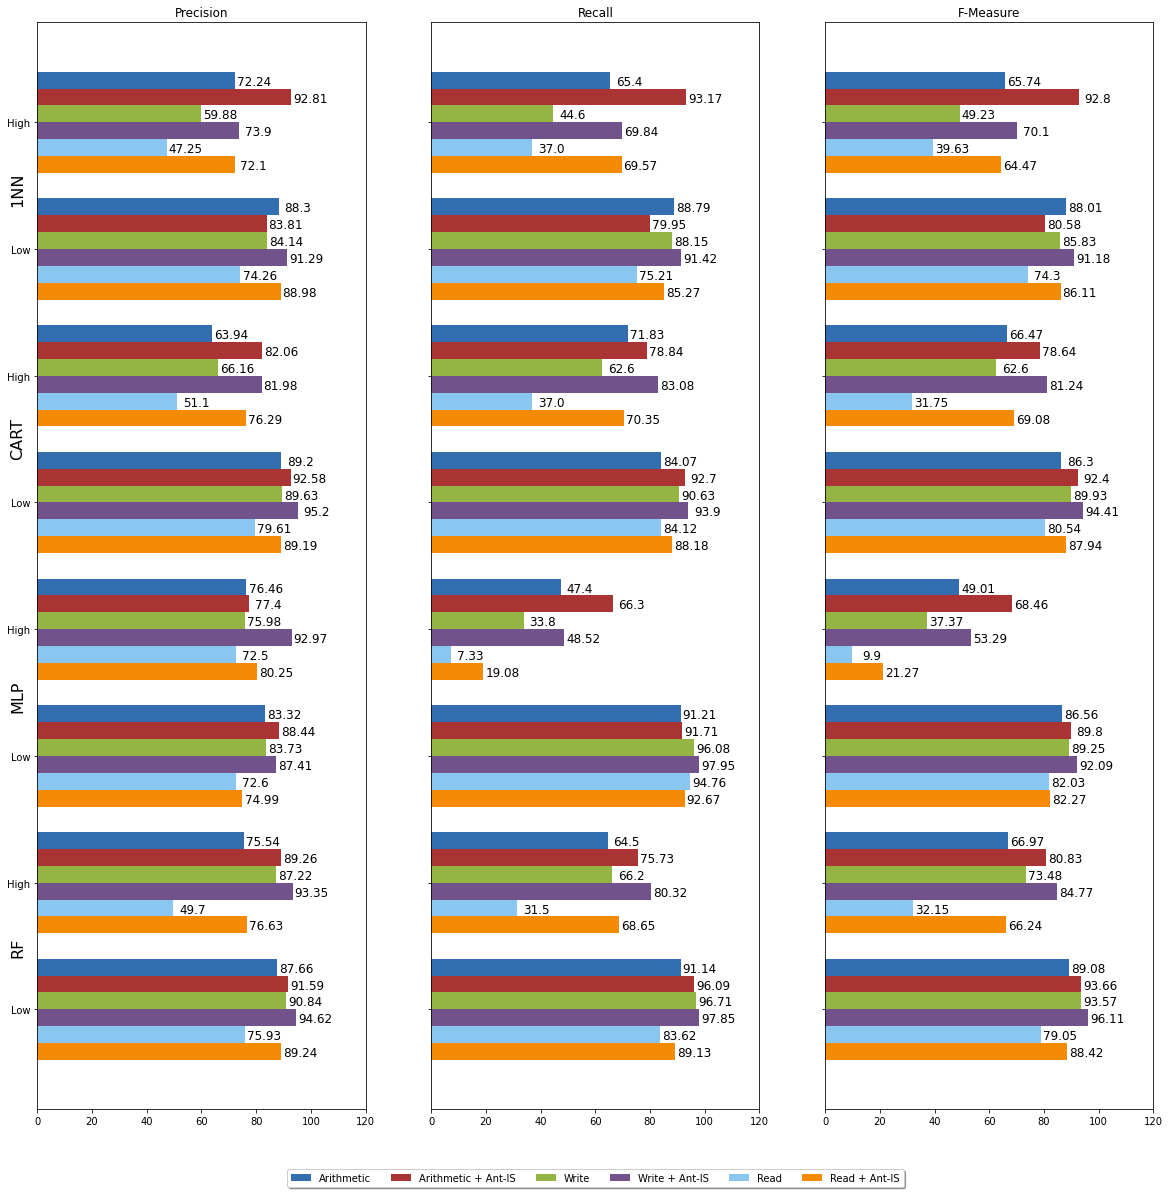

In [24]:

def autolabel(ax, rects):
    for rect in rects:
        width = rect.get_width()
        height = rect.get_height()
        ypos = rect.get_y() + height/2
        ax.text(width + 7.0, ypos - 0.09, width, ha='center', va='bottom', rotation=0, fontsize=12) 


def get_bars_per_dfs(df_arit, df_esc, df_leit):
    return ([
        round(df_arit["1nn"].loc["Superior"]*100, 2),
        round(df_arit["1nn"].loc["Inferior"]*100, 2),
        round(df_arit["cart"].loc["Superior"]*100, 2),
        round(df_arit["cart"].loc["Inferior"]*100, 2),
        round(df_arit["mlp"].loc["Superior"]*100, 2),
        round(df_arit["mlp"].loc["Inferior"]*100, 2),
        round(df_arit["random_forest"].loc["Superior"]*100, 2),
        round(df_arit["random_forest"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_arit["1nn/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_arit["1nn/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["cart/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["cart/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_arit["mlp/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["mlp/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_arit["random_forest/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["random_forest/Ant-IS"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_esc["1nn"].loc["Superior"]*100, 2),
        round(df_esc["1nn"].loc["Inferior"]*100, 2),
        round(df_esc["cart"].loc["Superior"]*100, 2),
        round(df_esc["cart"].loc["Inferior"]*100, 2),
        round(df_esc["mlp"].loc["Superior"]*100, 2),
        round(df_esc["mlp"].loc["Inferior"]*100, 2),
        round(df_esc["random_forest"].loc["Superior"]*100, 2),
        round(df_esc["random_forest"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_esc["1nn/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["1nn/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_esc["cart/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["cart/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_esc["mlp/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["mlp/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_esc["random_forest/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["random_forest/Ant-IS"].loc["Inferior"]*100, 2)
    ],
        [
        round(df_leit["1nn"].loc["Superior"]*100, 2),
        round(df_leit["1nn"].loc["Inferior"]*100, 2),
        round(df_leit["cart"].loc["Superior"]*100, 2),
        round(df_leit["cart"].loc["Inferior"]*100, 2),
        round(df_leit["mlp"].loc["Superior"]*100, 2),
        round(df_leit["mlp"].loc["Inferior"]*100, 2),
        round(df_leit["random_forest"].loc["Superior"]*100, 2),
        round(df_leit["random_forest"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_leit["1nn/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["1nn/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_leit["cart/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["cart/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_leit["mlp/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["mlp/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_leit["random_forest/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["random_forest/Ant-IS"].loc["Inferior"]*100, 2)
    ])


algo_labels = ['1NN', 'CART', 'MLP', 'RF']
bars_labels = ["Arithmetic", "Arithmetic + Ant-IS", "Write",
               "Write + Ant-IS", "Read", "Read + Ant-IS"]

full_arit_precision,  reduced_arit_precision, full_esc_precision, reduced_esc_precision, full_leit_precision, reduced_leit_precision = get_bars_per_dfs(
    arit_valid_precision_df,
    esc_valid_precision_df,
    leit_valid_precision_df)

number_columns = len(full_arit_precision)
number_groups = 6
fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3)
# Definindo o numero de colunas e o numero de agrupamentos


# Definindo a largura das barras
barWidth = 0.2

# Espaçamento entre barras
espacamentoEntreBarras = 0.00

# espaçamento de um grupo no outro
espacamentoEntreGrupos = 1.5

# Aumentando o gráfico
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['figure.titlesize'] = 'small'

def autolabels(ax, labels):
    for label in labels:
        autolabel(ax, label)


def get_bars_positions(num_groups, num_columns, ):
    bars = []
    for i in range(num_groups):
        if i == 0:
            bars.append([(x * espacamentoEntreGrupos + espacamentoEntreBarras)
                        * -1 for x in range(num_columns)])
            continue

        bars.append([x - barWidth - espacamentoEntreBarras for x in bars[-1]])

    return tuple(bars)


def get_labels(ax, data_per_bar, groups, colors, bar_labels):
    labels = []

    for i in range(len(groups)):
        label = ax.barh(groups[i], data_per_bar[i], barWidth,
                        color=colors[i], label=bar_labels[i])
        labels.append(label)

    return tuple(labels)


groups = get_bars_positions(number_groups, number_columns)
labels_precision = get_labels(ax0, [
    full_arit_precision,
    reduced_arit_precision,
    full_esc_precision,
    reduced_esc_precision,
    full_leit_precision,
    reduced_leit_precision
],
    groups,
    ["#336EB0", "#AA3333", "#94B444", "#71528A", "#8AC6EF", "#F58A07"],
    bars_labels
)

ax0.set_xticks(np.arange(0, 140, 20))
yticks = [r - barWidth - espacamentoEntreBarras - 0.3 for r in groups[0]]
ax0.set_yticks(yticks)


ax0.set_yticklabels(['High', 'Low', 'High',
                    'Low', 'High',  'Low', 'High', 'Low'])


y = yticks[0] + ((yticks[0] + yticks[1]) / 2) + 0.3
ax0.text(-10, y, algo_labels[0], rotation='vertical', fontsize=16)

y = yticks[1] + ((yticks[1] + yticks[2]) / 2) + 0.3
ax0.text(-10, y, algo_labels[1], rotation='vertical', fontsize=16)

y = yticks[2] + ((yticks[2] + yticks[3]) / 2) + 0.3
ax0.text(-10, y, algo_labels[2], rotation='vertical', fontsize=16)

y = yticks[3] + ((yticks[3] + yticks[4]) / 2) + 0.4
ax0.text(-10, y, algo_labels[3], rotation='vertical', fontsize=16)

ax0.set_title('Precision')
autolabels(ax0, labels_precision)


ax1.set_title('Recall')
bar1,  bar2, bar3, bar4, bar5, bar6 = get_bars_per_dfs(
    arit_valid_recall_df,
    esc_valid_recall_df,
    leit_valid_recall_df)

groups = get_bars_positions(number_groups, number_columns)
labels_recall = get_labels(ax1, [
    bar1,  bar2, bar3, bar4, bar5, bar6
],
    groups,
    ["#336EB0", "#AA3333", "#94B444", "#71528A", "#8AC6EF", "#F58A07"],
    bars_labels
)
autolabels(ax1, labels_recall)
ax1.set_xticks(np.arange(0, 140, 20))
ax1.set_yticks(yticks)
ax1.set_yticklabels([])


ax2.set_title('F-Measure')
bar1,  bar2, bar3, bar4, bar5, bar6 = get_bars_per_dfs(
    arit_valid_fmeasure_df,
    esc_valid_fmeasure_df,
    leit_valid_fmeasure_df
)

groups = get_bars_positions(number_groups, number_columns)
labels_fmesure = get_labels(ax2, [
    bar1,  bar2, bar3, bar4, bar5, bar6
],
    groups,
    ["#336EB0", "#AA3333", "#94B444", "#71528A", "#8AC6EF", "#F58A07"],
    bars_labels
)
autolabels(ax2, labels_fmesure)
ax2.set_xticks(np.arange(0, 140, 20))
ax2.set_yticks(yticks)
ax2.set_yticklabels([])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=6)

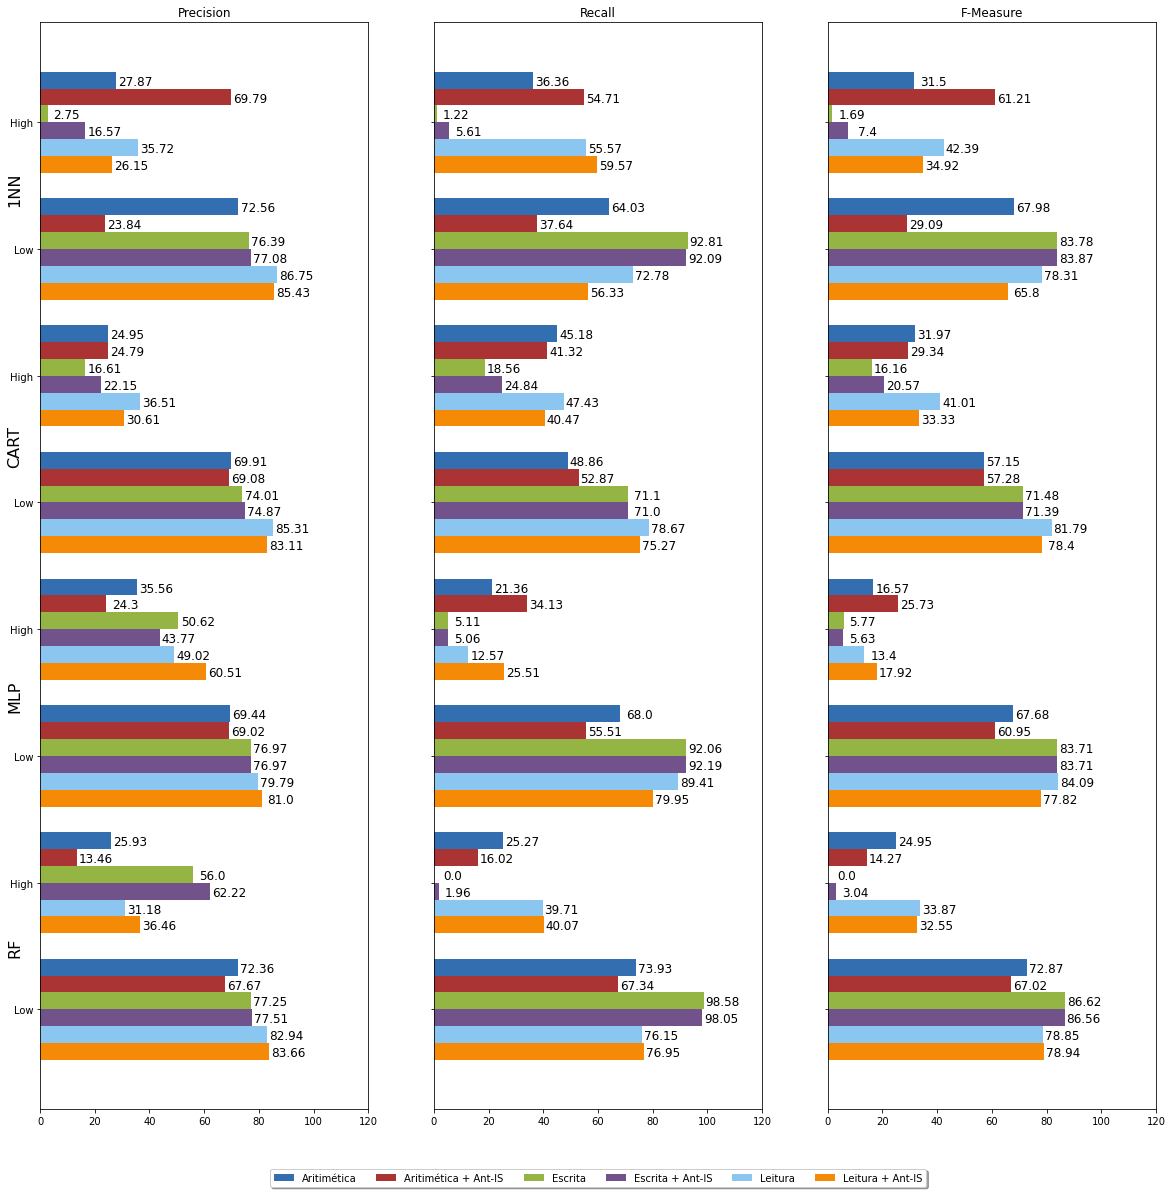

In [27]:
def get_bars_per_dfs(df_arit, df_esc, df_leit):
    return ([
        round(df_arit["1nn"].loc["Superior"]*100, 2),
        round(df_arit["1nn"].loc["Inferior"]*100, 2),
        round(df_arit["cart"].loc["Superior"]*100, 2),
        round(df_arit["cart"].loc["Inferior"]*100, 2),
        round(df_arit["mlp"].loc["Superior"]*100, 2),
        round(df_arit["mlp"].loc["Inferior"]*100, 2),
        round(df_arit["random_forest"].loc["Superior"]*100, 2),
        round(df_arit["random_forest"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_arit["1nn/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_arit["1nn/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["cart/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["cart/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_arit["mlp/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["mlp/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_arit["random_forest/Ant-IS"].loc["Superior"]*100, 2),
        round(df_arit["random_forest/Ant-IS"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_esc["1nn"].loc["Superior"]*100, 2),
        round(df_esc["1nn"].loc["Inferior"]*100, 2),
        round(df_esc["cart"].loc["Superior"]*100, 2),
        round(df_esc["cart"].loc["Inferior"]*100, 2),
        round(df_esc["mlp"].loc["Superior"]*100, 2),
        round(df_esc["mlp"].loc["Inferior"]*100, 2),
        round(df_esc["random_forest"].loc["Superior"]*100, 2),
        round(df_esc["random_forest"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_esc["1nn/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["1nn/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_esc["cart/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["cart/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_esc["mlp/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["mlp/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_esc["random_forest/Ant-IS"].loc["Superior"]*100, 2),
        round(df_esc["random_forest/Ant-IS"].loc["Inferior"]*100, 2)
    ],
        [
        round(df_leit["1nn"].loc["Superior"]*100, 2),
        round(df_leit["1nn"].loc["Inferior"]*100, 2),
        round(df_leit["cart"].loc["Superior"]*100, 2),
        round(df_leit["cart"].loc["Inferior"]*100, 2),
        round(df_leit["mlp"].loc["Superior"]*100, 2),
        round(df_leit["mlp"].loc["Inferior"]*100, 2),
        round(df_leit["random_forest"].loc["Superior"]*100, 2),
        round(df_leit["random_forest"].loc["Inferior"]*100, 2)
    ],

        [
        round(df_leit["1nn/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["1nn/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_leit["cart/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["cart/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_leit["mlp/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["mlp/Ant-IS"].loc["Inferior"]*100, 2),
        round(df_leit["random_forest/Ant-IS"].loc["Superior"]*100, 2),
        round(df_leit["random_forest/Ant-IS"].loc["Inferior"]*100, 2)
    ])


algo_labels = ['1NN', 'CART', 'MLP', 'RF']
bars_labels = ["Aritimética", "Aritimética + Ant-IS", "Escrita",
               "Escrita + Ant-IS", "Leitura", "Leitura + Ant-IS"]

full_arit_precision,  reduced_arit_precision, full_esc_precision, reduced_esc_precision, full_leit_precision, reduced_leit_precision = get_bars_per_dfs(
    arit_test_precision_df,
    esc_test_precision_df,
    leit_test_precision_df)

number_columns = len(full_arit_precision)
number_groups = 6
fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3)
# Definindo o numero de colunas e o numero de agrupamentos


# Definindo a largura das barras
barWidth = 0.2

# Espaçamento entre barras
espacamentoEntreBarras = 0.00

# espaçamento de um grupo no outro
espacamentoEntreGrupos = 1.5

# Aumentando o gráfico
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['figure.titlesize'] = 'small'

def autolabels(ax, labels):
    for label in labels:
        autolabel(ax, label)


def get_bars_positions(num_groups, num_columns, ):
    bars = []
    for i in range(num_groups):
        if i == 0:
            bars.append([(x * espacamentoEntreGrupos + espacamentoEntreBarras)
                        * -1 for x in range(num_columns)])
            continue

        bars.append([x - barWidth - espacamentoEntreBarras for x in bars[-1]])

    return tuple(bars)


def get_labels(ax, data_per_bar, groups, colors, bar_labels):
    labels = []

    for i in range(len(groups)):
        label = ax.barh(groups[i], data_per_bar[i], barWidth,
                        color=colors[i], label=bar_labels[i])
        labels.append(label)

    return tuple(labels)


groups = get_bars_positions(number_groups, number_columns)
labels_precision = get_labels(ax0, [
    full_arit_precision,
    reduced_arit_precision,
    full_esc_precision,
    reduced_esc_precision,
    full_leit_precision,
    reduced_leit_precision
],
    groups,
    ["#336EB0", "#AA3333", "#94B444", "#71528A", "#8AC6EF", "#F58A07"],
    bars_labels
)

ax0.set_xticks(np.arange(0, 140, 20))
yticks = [r - barWidth - espacamentoEntreBarras - 0.3 for r in groups[0]]
ax0.set_yticks(yticks)


ax0.set_yticklabels(['High', 'Low', 'High',
                    'Low', 'High',  'Low', 'High', 'Low', ])


y = yticks[0] + ((yticks[0] + yticks[1]) / 2) + 0.3
ax0.text(-12, y, algo_labels[0], rotation='vertical', fontsize=16)

y = yticks[1] + ((yticks[1] + yticks[2]) / 2) + 0.2
ax0.text(-12, y, algo_labels[1], rotation='vertical', fontsize=16)

y = yticks[2] + ((yticks[2] + yticks[3]) / 2) + 0.3
ax0.text(-12, y, algo_labels[2], rotation='vertical', fontsize=16)

y = yticks[3] + ((yticks[3] + yticks[4]) / 2) + 0.4
ax0.text(-12, y, algo_labels[3], rotation='vertical', fontsize=16)


ax0.set_title('Precision')
autolabels(ax0, labels_precision)


ax1.set_title('Recall')
bar1,  bar2, bar3, bar4, bar5, bar6 = get_bars_per_dfs(
    arit_test_recall_df,
    esc_test_recall_df,
    leit_test_recall_df)

groups = get_bars_positions(number_groups, number_columns)
labels_recall = get_labels(ax1, [
    bar1,  bar2, bar3, bar4, bar5, bar6
],
    groups,
    ["#336EB0", "#AA3333", "#94B444", "#71528A", "#8AC6EF", "#F58A07"],
    bars_labels
)
autolabels(ax1, labels_recall)
ax1.set_xticks(np.arange(0, 140, 20))
ax1.set_yticks(yticks)
ax1.set_yticklabels([])


ax2.set_title('F-Measure')
bar1,  bar2, bar3, bar4, bar5, bar6 = get_bars_per_dfs(
    arit_test_fmeasure_df,
    esc_test_fmeasure_df,
    leit_test_fmeasure_df
)

groups = get_bars_positions(number_groups, number_columns)
labels_fmesure = get_labels(ax2, [
    bar1,  bar2, bar3, bar4, bar5, bar6
],
    groups,
    ["#336EB0", "#AA3333", "#94B444", "#71528A", "#8AC6EF", "#F58A07"],
    bars_labels
)
autolabels(ax2, labels_fmesure)
ax2.set_xticks(np.arange(0, 140, 20))
ax2.set_yticks(yticks)
ax2.set_yticklabels([])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=6)


In [ ]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, height, ha='center', va='bottom', rotation=90, fontsize=12)   
        #print(height)     

#Valores dos agrupamentos
Borro = [49.3, 29.5, 51.5, 89.1, 75.6, 28.3, 53.9]
Leijoto = [62.1, 73.5, 62.1, 78.6, 75.5, 76.7, 71.4]
Santos  = [69.7, 65.3, 96.2, 100.0, 69.8, 86.3, 78.4]
Metodologia  = [65.0, 73.6, 80.0, 87.0,  74.5, 83.9, 77.3]

#Definindo o numero de colunas e o numero de agrupamentos
number_columns = len(Borro)
number_groups = 4 

# Definindo a largura das barras
barWidth = 0.21

#Espaçamento entre barras
espacamentoEntreBarras = 0.00

#espaçamento de um grupo no outro
espacamentoEntreGrupos = 1.2

# Aumentando o gráfico
plt.rcParams['figure.figsize'] = (15,7)

fig, ax = plt.subplots()

# Definindo a posição das barras
#r1 = np.arange(len(Borro))
r1 = [x * espacamentoEntreGrupos + espacamentoEntreBarras for x in range(number_columns)]
r2 = [x + barWidth + espacamentoEntreBarras for x in r1]
r3 = [x + barWidth + espacamentoEntreBarras for x in r2]
r4 = [x + barWidth + espacamentoEntreBarras for x in r3]
 
# Criando as barras
label1 = plt.bar(r1, Borro, color='#704F97', width=barWidth, label='Borro et al (2006)')
label2 = plt.bar(r2, Leijoto, color='#91B643', width=barWidth, label='Leijôto (2014)')
label3 = plt.bar(r3, Santos, color='#AF3330', width=barWidth, label='Santos (2016)')
label4 = plt.bar(r4, Metodologia, color='#3771B8', width=barWidth, label='Metodologia Proposta')
 
# Adicionando legendas nas barras
plt.xlabel('Class protein')
plt.xticks([r + barWidth + espacamentoEntreBarras + 0.15 for r in r1], ['Tra.', 'Oxi.', 'Lia.', 'Lig.', 'Iso.', 'Hid.', 'Ave.'])

plt.ylabel('Precision')
plt.yticks(np.arange(0, 120, 10))

plt.title('Comparison between methodologies')


#preenche os valores nas barras
autolabel(label1)
autolabel(label2)
autolabel(label3)
autolabel(label4)

#Coloca a legenda fora do gráfico
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), fancybox=True, shadow=True, ncol=4)

# Criando a legenda e exibindo o gráfico
#plt.legend()
plt.show()
#plt.savefig('drive/My Drive/GraficosPython/'+ 'graficoExemplo.png')

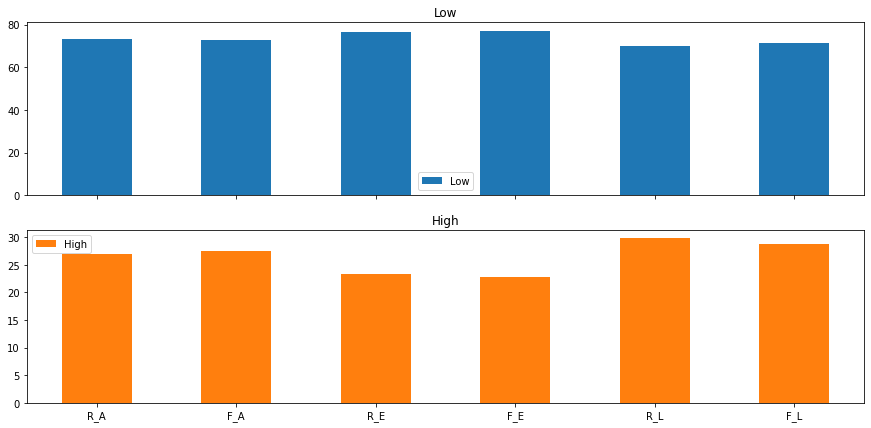

In [39]:
# reduced_inferior_arit, reduced_superior_arit = get_class_balance(arit, True)
# reduced_inferior_esc, reduced_superior_esc = get_class_balance(esc, True)
# reduced_inferior_leit, reduced_superior_leit = get_class_balance(leit, True)

# full_inferior_arit, full_superior_arit = get_class_balance(arit, False)
# full_inferior_esc, full_superior_esc = get_class_balance(esc, False)
# full_inferior_leit, full_superior_leit = get_class_balance(leit, False)

class_index = ["R_A", "F_A", "R_E", "F_E", "R_L", "F_L"]
infs = [
    np.mean(reduced_inferior_arit)*100, 
    np.mean(full_inferior_arit)*100,
    np.mean(reduced_inferior_esc)*100, 
    np.mean(full_inferior_esc)*100,
    np.mean(reduced_inferior_leit)*100, 
    np.mean(full_inferior_leit)*100,
]
sups = [
    np.mean(reduced_superior_arit)*100, 
    np.mean(full_superior_arit)*100,
    np.mean(reduced_superior_esc)*100, 
    np.mean(full_superior_esc)*100,
    np.mean(reduced_superior_leit)*100, 
    np.mean(full_superior_leit)*100,
]

df_for_view = pd.DataFrame({'Low': infs, 'High': sups}, index=class_index)
axes = df_for_view.plot.bar(rot=0, subplots=True, )




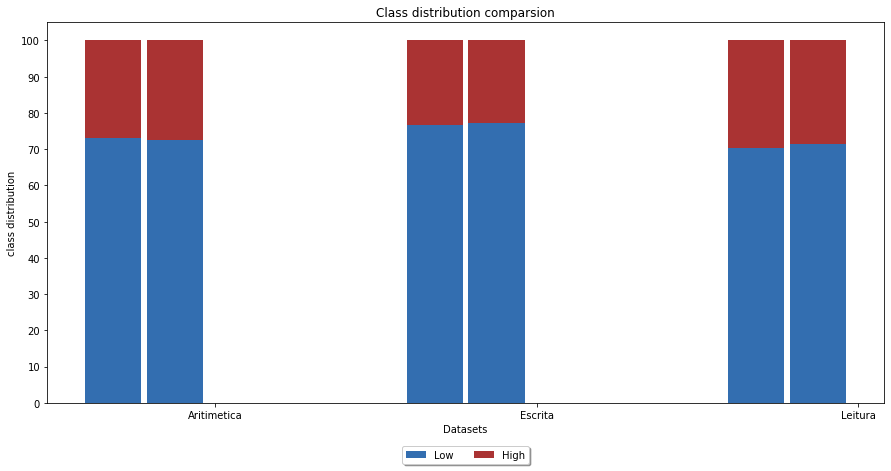

In [60]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, height, ha='center', va='bottom', rotation=90, fontsize=12)   
        #print(height)     


arit_inf_ratios = [infs[0], infs[1]]
arit_sup_ratios = [sups[0], sups[1]]

esc_inf_ratios = [infs[2], infs[3]]
esc_sup_ratios = [sups[2], sups[3]]

leit_inf_ratios = [infs[4], infs[5]]
leit_sup_ratios = [sups[4], sups[5]]

reduced_inf = [infs[0], infs[2], infs[4]]
reduced_sup = [sups[0], sups[2], sups[4]]

full_inf = [infs[1], infs[3], infs[5]]
full_sup = [sups[1], sups[3], sups[5]]


#Definindo o numero de colunas e o numero de agrupamentos
number_columns = len(reduced_inf)
number_groups = 2

# Definindo a largura das barras
barWidth = 0.21

#Espaçamento entre barras
espacamentoEntreBarras = 0.02

#espaçamento de um grupo no outro
espacamentoEntreGrupos = 1.2

# Aumentando o gráfico
plt.rcParams['figure.figsize'] = (15,7)

fig, ax = plt.subplots()

# Definindo a posição das barras
#r1 = np.arange(len(Borro))
r1 = [x * espacamentoEntreGrupos + espacamentoEntreBarras for x in range(number_columns)]
r2 = [x + barWidth + espacamentoEntreBarras for x in r1]
 
# Criando as barras
# "#336EB0", "#AA3333", "#94B444", "#71528A", "#8AC6EF", "#F58A07"
label1 = plt.bar(r1, reduced_inf, color='#336EB0', width=barWidth, label='Low')
label1 = plt.bar(r1, reduced_sup, bottom=reduced_inf, color='#AA3333', width=barWidth, label='High')

label2 = plt.bar(r2, full_inf, color='#336EB0', width=barWidth)
label2 = plt.bar(r2, full_sup, bottom=full_inf,color='#AA3333', width=barWidth)

 
# Adicionando legendas nas barras
plt.xlabel('Datasets')
plt.xticks([r + barWidth + espacamentoEntreBarras + 0.15 for r in r1], ['Aritimetica', 'Escrita','Leitura'])

plt.ylabel('class distribution')
plt.yticks(np.arange(0, 110, 10))

plt.title('Class distribution comparsion')


#preenche os valores nas barras
#autolabel(label1)
#autolabel(label2)
#autolabel(label3)


#Coloca a legenda fora do gráfico
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), fancybox=True, shadow=True, ncol=2)

# Criando a legenda e exibindo o gráfico
#plt.legend()
plt.show()
#plt.savefig('drive/My Drive/GraficosPython/'+ 'graficoExemplo.png')